In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Face-Emotion-Recognition-Project' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.gitignore', 'LICENSE', 'README.md', 'src', 'models', 'personal_dataset', '.git', '.vscode', '__pycache__', 'CW_Dataset', 'train_hog_naive_bayes.ipynb', 'train_function.ipynb', 'hyper-parameter-tuning and training models.ipynb', 'SVM-SIFT train dummy.ipynb', 'References .gdoc', '.ipynb_checkpoints', 'SVM-HOG train dummy.ipynb', 'Copy of SVM-SIFT train dummy.ipynb', 'train_sift_naive_bayes.ipynb', 'Copy of SVM-HOG train dummy.ipynb', 'MLP-HOG train .ipynb', 'SIFT_MLP.ipynb', 'Pre-trained CNN and MLP training.ipynb', 'test_function.ipynb', 'Data Exploration and SIFT-SVM Models.ipynb']


In [ ]:
import sys
modules_needed = ['models','models/feature_descriptors','models/lib','src']
for i in modules_needed:
  if i not in sys.path:
    CODE_PATH = os.path.join(GOOGLE_DRIVE_PATH,i )
    sys.path.append(CODE_PATH)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
zip_path = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [ ]:
from data_loader import import_selected_data, shuffleData
from preprocessing import *
from collections import  Counter
import numpy as np


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
!pip install opencv-python==4.4.0.46

     |████████████████████████████████| 49.5MB 63kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
import cv2
from skimage import img_as_ubyte, io, color
from sklearn import metrics
import matplotlib.pyplot as plt


%matplotlib inline

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


In [ ]:
X_train,y_train = import_selected_data('train')
X_train, y_train = shuffleData(X_train, y_train)

In [ ]:
import torch
from torch import optim, nn
from torchvision import models, transforms

In [ ]:
vgg16_model = models.vgg16(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The following code has been adapted from here - https://towardsdatascience.com/image-feature-extraction-using-pytorch-e3b327c3607a

In [ ]:
class VGG16_FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(VGG16_FeatureExtractor, self).__init__()
		# Extracting VGG-16 Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
		# Extract VGG-16 Average Pooling Layer
    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    self.fc = model.classifier[0]
  
  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    out = self.fc(out) 
    return out 


In [ ]:
new_model = VGG16_FeatureExtractor(vgg16_model)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

In [ ]:
print(new_model)

VGG16_FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pa

In [ ]:
transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.CenterCrop(512),
  transforms.Resize(448),
  transforms.ToTensor()                              
])

In [ ]:
features_list = []
for i in range(len(X_train)):
  new_img = transform(X_train[i])
  new_img = new_img.reshape(1,3,448,448)
  new_img = new_img.to(device)

  with torch.no_grad():
    f = new_model(new_img)
  features_list.append(f.cpu().detach().numpy().reshape(-1))


extracted_features = np.array(features_list)

In [ ]:
len(extracted_features)

12271

In [ ]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


In [ ]:
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from time import time
import numpy as np

In [ ]:
from time import time

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [ ]:
mlp_params= {"hidden_layer_sizes":
                 [(150,100,50,25, ), (100, 50, 25, )],
                  "activation": ["relu"], "solver": ["adam"], 'alpha': [0.0001],
                  "batch_size":[1000]
             
             }

In [ ]:
pipe = make_pipeline(SMOTE(sampling_strategy={2:700}), preprocessing.StandardScaler(), MLPClassifier(max_iter=400))

In [ ]:
new_params = {'mlpclassifier__' + key: mlp_params[key] for key in mlp_params}

In [ ]:
mlp_grid_cv = GridSearchCV(pipe, param_grid=new_params,verbose=3,n_jobs=-1, cv = cv )

In [ ]:
time_initial = time()
predicted_mlp = mlp_grid_cv.fit(extracted_features,y_train)
print("done in %0.3fs" % (time() - time_initial))

Fitting 15 folds for each of 2 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 46.9min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


done in 2903.715s


In [ ]:
mlp_grid_cv.best_params_

{'mlpclassifier__activation': 'relu',
 'mlpclassifier__alpha': 0.0001,
 'mlpclassifier__batch_size': 1000,
 'mlpclassifier__hidden_layer_sizes': (150, 100, 50, 25),
 'mlpclassifier__solver': 'adam'}

In [ ]:
mlp_grid_cv.best_score_

0.540976755740797

In [ ]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/cnn_mlp_.joblib')
dump(mlp_grid_cv, filename)

['drive/My Drive/Colab Notebooks/Face-Emotion-Recognition-Project/models/lib/cnn_mlp_.joblib']

In [ ]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/cnn_mlp_.joblib')
loaded_cnn_mlp = load(filename)

In [ ]:
X_test, y_test = import_selected_data('test')

In [ ]:
test_features_list = []
for i in range(len(X_test)):
  test_new_img = transform(X_test[i])
  test_new_img = test_new_img.reshape(1,3,448,448)
  test_new_img = test_new_img.to(device)

  with torch.no_grad():
    f = new_model(test_new_img)
  test_features_list.append(f.cpu().detach().numpy().reshape(-1))


In [ ]:
extracted_test_features = np.array(test_features_list)

In [ ]:
import numpy

In [ ]:
filename =os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/extracted_features.npy')
numpy.save(filename,extracted_test_features)

In [ ]:
p = numpy.load(filename)

In [ ]:
len(p)

3068

In [ ]:
predicted = loaded_cnn_mlp.predict(extracted_test_features).tolist()

In [ ]:
print(f"""Classification report for classifier {loaded_cnn_mlp}:
      {metrics.classification_report(y_test, predicted)}\n""")

Classification report for classifier GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=None, ratio=None,
                                              sampling_strategy={2: 700},
                                              svm_estimator='deprecated')),
                                       ('standardscaler',
                                        StandardScal...
                                                      warm_start=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_g

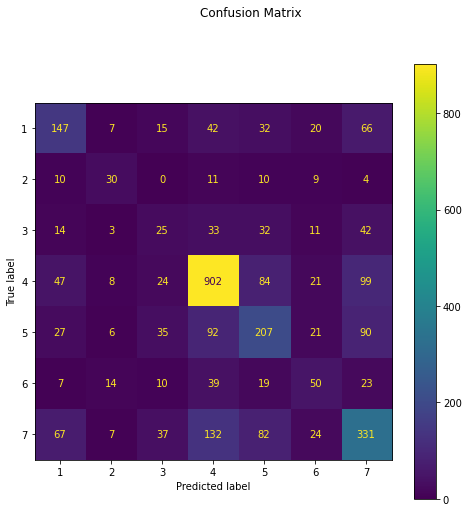

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = metrics.plot_confusion_matrix(loaded_cnn_mlp, list(extracted_test_features), y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.utils import  shuffle

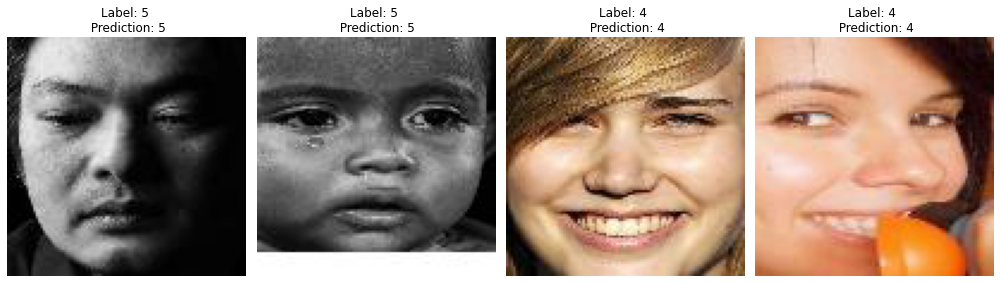

In [ ]:
X_test, y_test, predicted = shuffle(X_test , y_test, predicted)
#X_test_img = X_test.reshape(-1, 100, 100)


fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(4):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {predicted[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

Getting Features for personal data set

In [ ]:
zip_path = os.path.join(GOOGLE_DRIVE_PATH,'personal_dataset/personal_dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q personal_dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm personal_dataset.zip

In [ ]:
from data_loader import import_personal_data
from FaceRecognition import detectFace
from skimage.transform import resize
from skimage import img_as_ubyte

In [ ]:
X,y = import_personal_data('personal-test-images')

cropped_X = []
for i in range(len(X)):
  f = detectFace(X[i])
  cropped_X.append(img_as_ubyte(resize(f,(100,100))))

personalX = cropped_X
personalY = y

drive/My Drive/Colab Notebooks/Face-Emotion-Recognition-Project/src/data_loader.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images), np.array(labels)


In [ ]:
transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.CenterCrop(512),
  transforms.Resize(448),
  transforms.ToTensor()                              
])

In [ ]:
personal_test_features_list = []
for i in range(len(personalX)):
  test_new_img = transform(personalX[i])
  test_new_img = test_new_img.reshape(1,3,448,448)
  test_new_img = test_new_img.to(device)

  with torch.no_grad():
    f = new_model(test_new_img)
  personal_test_features_list.append(f.cpu().detach().numpy().reshape(-1))

In [ ]:
extracted_personal_test_features = np.array(personal_test_features_list)

In [ ]:
filename =os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/extracted_personal_test_features.npy')
numpy.save(filename,extracted_personal_test_features)